# Task 4. 
Based on what you learned in Task 3, revisit HW2b by  using XGBoost and SHAP, and develop a Jupyter Notebook tutorial for end-to-end explainable machine learning  for the solubility prediction task.    (HW10d.ipynb) (30 points)

# Develop a ML model to predict measured log solubility

### Look at the big picture

This model's task is to predict **measured log solubility** using the following 5 features listed in the dataset: Molecular Weight, Number of H-Bond Donors, Number of Rings, Number of Rotatable Bonds, Polar Surface Area.

This is a supervised learning task since the model will be trained with labelled data. The task is a univariate multiple regression problem, since the model will use multiple features to predict one value. We will use RMSE as the performance measure and also take a look at the correlation coefficient.

### Import and prepare data

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

In [2]:
esol_data = pd.read_csv("delaney_processed.csv")

# drop the columns which will not be used in the model
esol_data = esol_data.drop(columns=[
    'Compound ID',
    'ESOL predicted log solubility in mols per litre', 
    'Minimum Degree', 
    'smiles'])

In [4]:
np.random.seed(23)
# split the training set
train_set, valid_and_test_set = train_test_split(esol_data, train_size=0.8)

# split remainder into validation set and test set
valid_set, test_set = train_test_split(valid_and_test_set, test_size=0.5)

In [34]:
X_train = train_set.drop('measured log solubility in mols per litre', axis=1)
y_train = train_set['measured log solubility in mols per litre']

X_valid = valid_set.drop('measured log solubility in mols per litre', axis=1)
y_valid = valid_set['measured log solubility in mols per litre']

X_test = test_set.drop('measured log solubility in mols per litre', axis=1)
y_test = test_set['measured log solubility in mols per litre']

### Explore data

Based on my explorations in HW2b, I predicted ```Molecular Weight``` and ```Number of rings``` as the most promising features to predict measured log solubility, due to strong linear correlations between two features and solubility.

### Prepare the data

In [35]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [37]:
feature_pipe = make_pipeline(FunctionTransformer(np.cbrt), StandardScaler())

X_train = feature_pipe.fit_transform(X_train)
X_valid = feature_pipe.transform(X_valid)
X_test = feature_pipe.transform(X_test)

### Train XGBoost model

In [17]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [38]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

train_pred = model.predict(X_train)
valid_pred = model.predict(X_valid)

train_rmse = mean_squared_error(y_train, train_pred, squared=False)
valid_rmse = mean_squared_error(y_valid, valid_pred, squared=False)

print("train set RMSE:", train_rmse)
print("valid set RMSE:", valid_rmse)

train set RMSE: 0.21229683107451033
valid set RMSE: 0.8743470409097106


### Fine-tune the model

In [39]:
from sklearn.model_selection import GridSearchCV

In [46]:
param_grid = ({'learning_rate': [0.1, 0.01, 0.001], 
               'colsample_bytree': [0.4, 1],
               'subsample': [0.8, 1],
               'n_estimators': [500, 1000], 
               'max_depth': [3, 5, 6], 
               'gamma': [0, 1, 10]})

grid_search = GridSearchCV(xgb.XGBRegressor(), param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 5,
 'n_estimators': 1000,
 'subsample': 0.8}

In [47]:
final_model = grid_search.best_estimator_

train_pred = final_model.predict(X_train)
valid_pred = final_model.predict(X_valid)
test_pred = final_model.predict(X_test)

train_rmse = mean_squared_error(y_train, train_pred, squared=False)
valid_rmse = mean_squared_error(y_valid, valid_pred, squared=False)
test_rmse = mean_squared_error(y_test, test_pred, squared=False)

print("train set RMSE:", train_rmse)
print("valid set RMSE:", valid_rmse)
print("test set RMSE:", test_rmse)

train set RMSE: 0.4650723731982917
valid set RMSE: 0.844997776589764
test set RMSE: 0.7919309672656195


### Feature importances

In [48]:
import shap

In [64]:
feature_names = train_set.drop('measured log solubility in mols per litre', axis=1).columns
explainer = shap.Explainer(final_model, feature_names=feature_names)

train_shap_values = explainer(X_train)
valid_shap_values = explainer(X_valid)
test_shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [65]:
# visualize training set predictions with a force plot
shap.initjs()
shap.plots.force(train_shap_values)

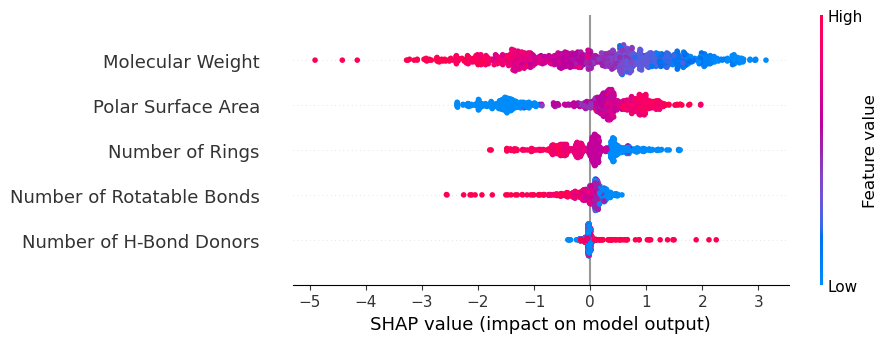

In [66]:
# summarize the effects of the features in the training set
shap.plots.beeswarm(train_shap_values)

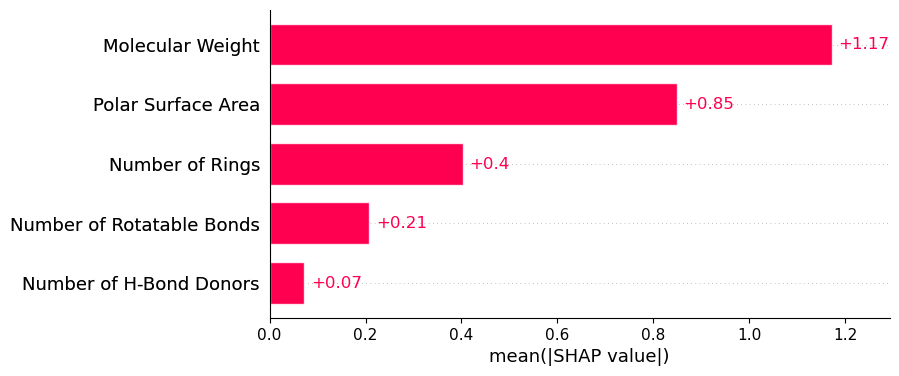

In [67]:
# training set feature importance via mean absolute value
shap.plots.bar(train_shap_values)

Based on the shapely values, ```Molecular Weight``` and ```Polar Surface Area``` have the biggest contributions to making predictions on the training set. Earlier, during data exploration, I hypothesized that ```Molecular Weight``` and ```Number of Rings``` would be the most important. ```Number of Rings``` likely made a smaller contribution than predicted due to it being discrete values with a small range.

We can compare to feature importance on the validation and test sets:

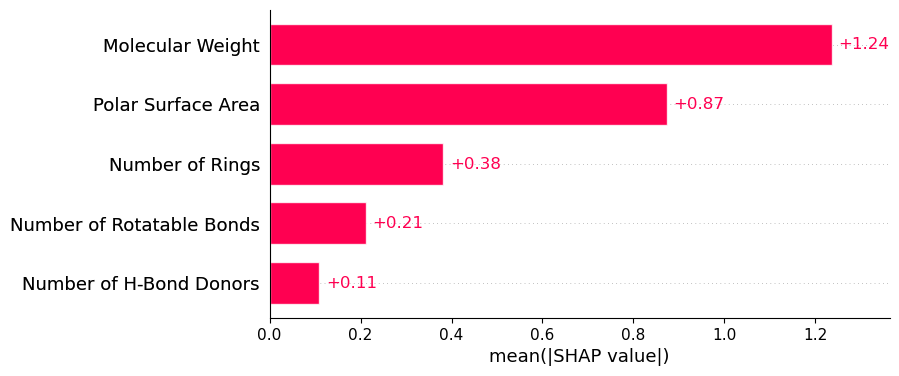

In [68]:
# validation set feature importance via mean absolute value
shap.plots.bar(valid_shap_values)

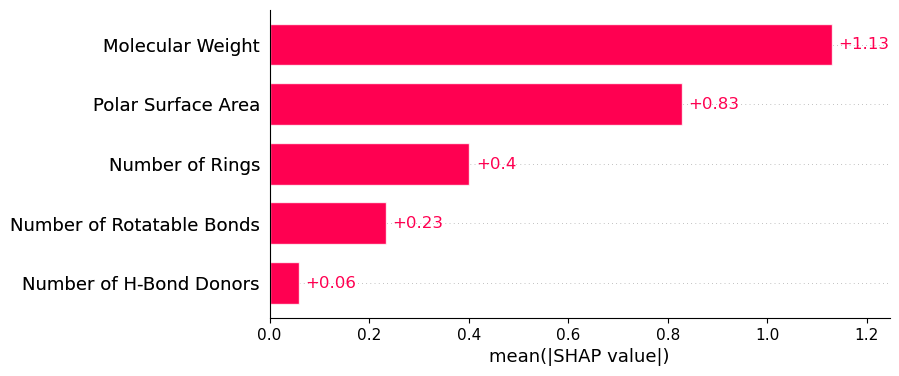

In [69]:
# test set feature importance via mean absolute value
shap.plots.bar(test_shap_values)

As expected, feature importance does not vary between training/validation/test sets. For this supervised learning task of predicting measured log solubility using an XGBRegressor, predictions are best explained by ```Molecular Weight``` and ```Polar Surface Area```.